# Описательная статистика

## О датасете

Ссылка |
-- |
https://www.kaggle.com/nikdavis/steam-store-games |

Столбец | Описание
-- | --
appid | ИД
name | Название
release_date | Дата релиза
developer | Разработчики
publisher | Издатели
platforms | Платформы
categories | Категории
genres | Жанры
positive_ratings | Кол-во положительных рейтингов
negative_ratings | Кол-во отрицательных рейтингов
average_playtime | Среднее время в игре
median_playtime | Срединное время в игре
owners | Кол-во продаж
price | Цена (в фунтах стерлингов)

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Загрузим основной датасет в память и проверим, что все получилось.

In [18]:
df = pd.read_csv('data/steam.csv')

In [19]:
df.sample(2)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
22016,851110,Idle Racing GO: Clicker Tycoon,2019-01-01,1,T-Bull S.A.,T-Bull S.A.,windows;mac,0,Single-player;In-App Purchases,Casual;Racing;Simulation;Early Access,Early Access;Racing;Simulation,90,47,71,0,0,20000-50000,0.00
4784,347690,Natural Soccer,2015-02-02,1,Thorsten Schleinzer,Thorsten Schleinzer,windows,0,Single-player;Multi-player;Shared/Split Screen...,Action;Indie;Sports,Action;Indie;Sports,12,35,17,0,0,0-20000,6.99


Проверим на пропуски.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27075 non-null  object 
 5   publisher         27075 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

## Сделаем подготовительную работу для проверки гипотез и дальнейшей работы с этими данными в следующих работах.

In [21]:
# Напишем сплющивающую функцию для работы с многозначными полями в датафрейме, вскоре нам это пригодится.

import collections
import itertools


def flatten(column):
    _temp = [p.split(';') for p in column]
    return list(itertools.chain.from_iterable(_temp))

In [22]:
flatten(df.categories[:3])

['Multi-player',
 'Online Multi-Player',
 'Local Multi-Player',
 'Valve Anti-Cheat enabled',
 'Multi-player',
 'Online Multi-Player',
 'Local Multi-Player',
 'Valve Anti-Cheat enabled',
 'Multi-player',
 'Valve Anti-Cheat enabled']

In [23]:
# Вынесем год издания игры в отдельный столбец для удобства
df['release_year'] = pd.DatetimeIndex(df['release_date']).year

In [24]:
# Чтобы как-то осмысленно поработать с количеством пользователей,
# возьмем верхнюю границу интервала, который приведен в датасете.

df.owners = df.owners.str.replace('\d+-', '')
df.owners = pd.to_numeric(df.owners)

Сделаем несколько агрегаций для следующих лабораторных.

In [49]:
_df = df[df.median_playtime > 0][df.price > 0][df.release_year < 2019][df.required_age > 0]

_df[['median_playtime', 'release_year', 'price', 'required_age']].groupby \
    (['release_year']).median().to_csv('yearly-median-agg.csv')

<ipython-input-49-92e592573ed0>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = df[df.median_playtime > 0][df.price > 0][df.release_year < 2019][df.required_age > 0]


In [120]:
_temp = pd.DataFrame(df.publisher.str.split(';').tolist(), index=df.owners).stack()
_temp = _temp.reset_index()[[0, 'owners']]
_temp.columns = ['publisher', 'owners']

_temp.groupby('publisher').sum().sort_values(by='owners', ascending=False).to_csv('publishers.csv')

In [121]:
_temp = pd.DataFrame(df.developer.str.split(';').tolist(), index=df.owners).stack()
_temp = _temp.reset_index()[[0, 'owners']]
_temp.columns = ['developer', 'owners']

_temp.groupby('developer').sum().sort_values(by='owners', ascending=False).to_csv('developers.csv')

## Проверяем гипотезы

### Количество игр на площадке растет экспоненциально

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 <a list of 22 Text xticklabel objects>)

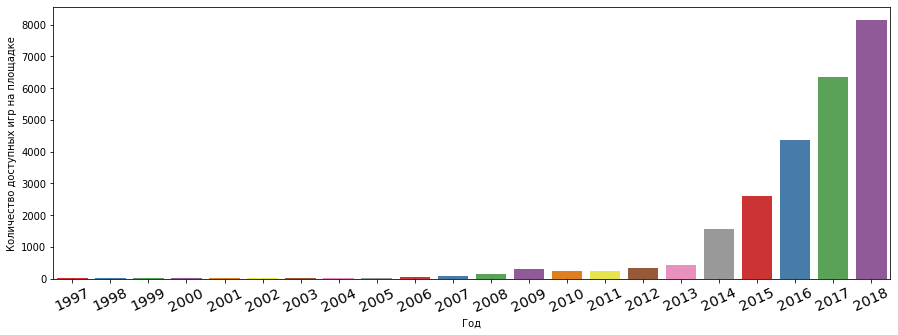

In [122]:
plt.figure(figsize=(15,5))

ax = sns.barplot(
    x=sorted(set(df.release_year))[:-1],
    y=df.groupby('release_year').count().owners[:-1],
    palette='Set1'
)

ax.set(xlabel='Год', ylabel='Количество доступных игр на площадке')
plt.xticks(rotation=25, horizontalalignment='center', fontweight='light', fontsize='x-large')

Похоже, что мы были правы! Замечание: выкинули последний год, потому что сам датасет собирался в начале 2019.

### Windows –– самая популярная игровая платформа

(-1.1032014263468737,
 1.1001524756038639,
 -1.119790740514518,
 1.1025829889714132)

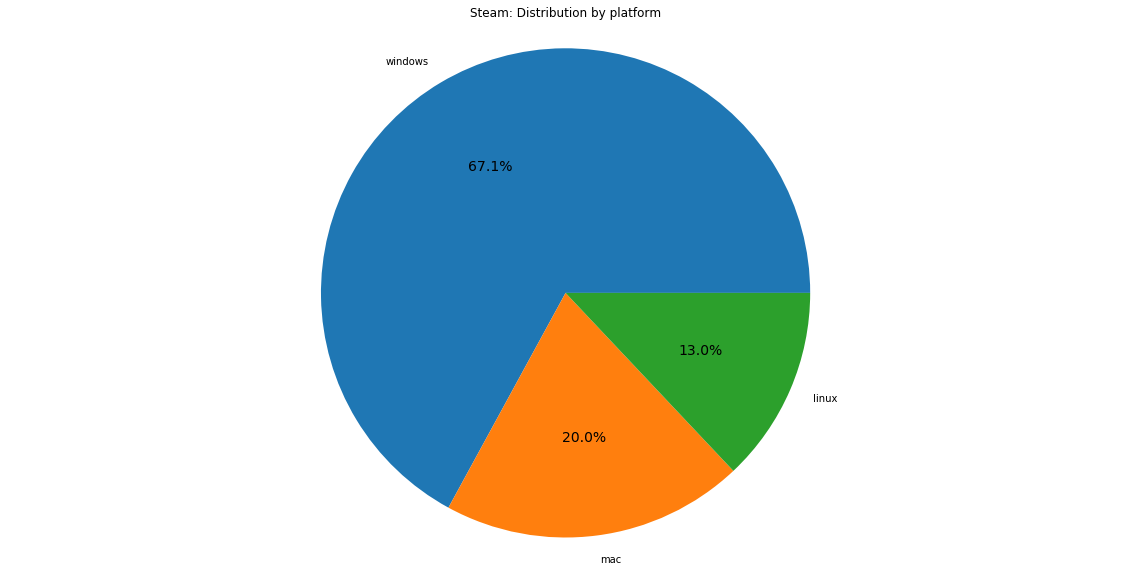

In [123]:
_platforms = collections.Counter(flatten(df.platforms))

labels = _platforms.keys()
values = _platforms.values()

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(aspect="equal"))

_, _, autotexts = plt.pie(values, labels=labels, autopct='%1.1f%%')

plt.setp(autotexts, size=14, weight='light')

ax.set_title("Steam: Distribution by platform")

plt.axis('equal')

Действительно, большинство игр выпускается под Windows.

### Инди –– самый распространенный жанр на площадке

(-1.1103141330480817,
 1.17938500513346,
 -1.1044951315147813,
 1.1596563448362072)

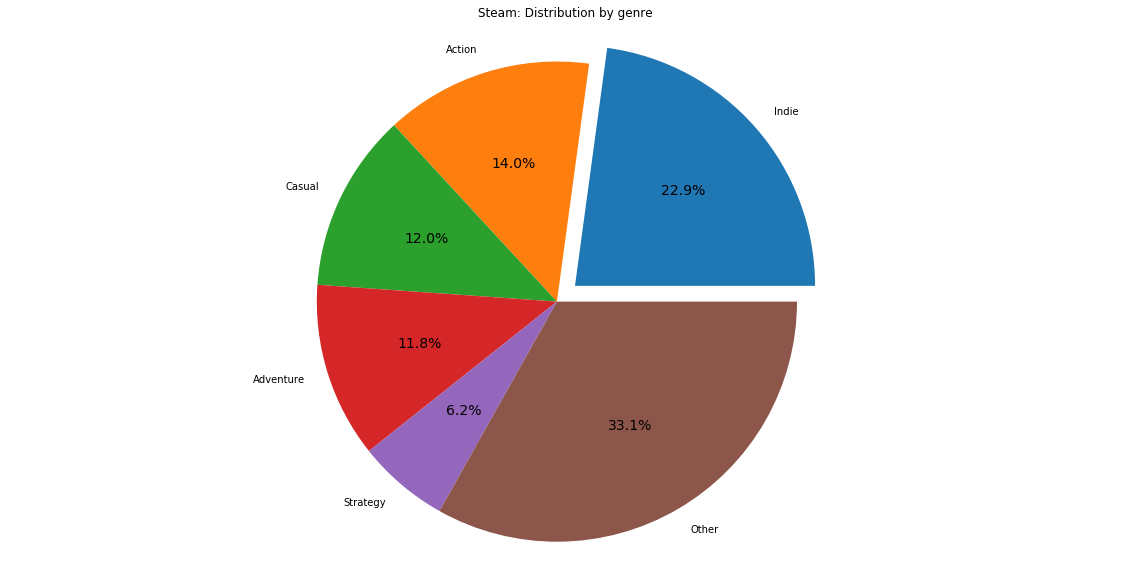

In [124]:
_genres = collections.Counter(flatten(df.genres))

# Отберем топ-5 жанров.
_top_genres = _genres.most_common(5)

# Остальные сгруппируем и добавим как "Other".
labels = [name for name, _ in _top_genres] + ['Other']
values = [count for _, count in _top_genres] + [sum(list(_genres.values())[5:])]

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = plt.pie(values, labels=labels, 
                                   autopct='%1.1f%%', explode=[0.1] + [0 for _ in range(len(values) - 1)])

plt.setp(autotexts, size=14, weight="light")

ax.set_title("Steam: Distribution by genre")

plt.axis('equal')

Итак, больше всего игр на площадке от **независимых разработчиков (больше 20\%)**, что неудивительно, учитывая что взнос за публикацию игры составляет всего $100 при таких масштабах аудитории, как в Steam. Затем следуют игры в жанрах **Экшн (14\%)**, **Казуальная и Приключенческая (12\%)**, и **Стратегия (6\%)**. **Оставшаяся треть** жанров состоит из категорий, по отдельности составляющих менее 5\% от всех жанров, так что мы их не покажем.

### Корелляционная матрица может показать неожиданные закономерности

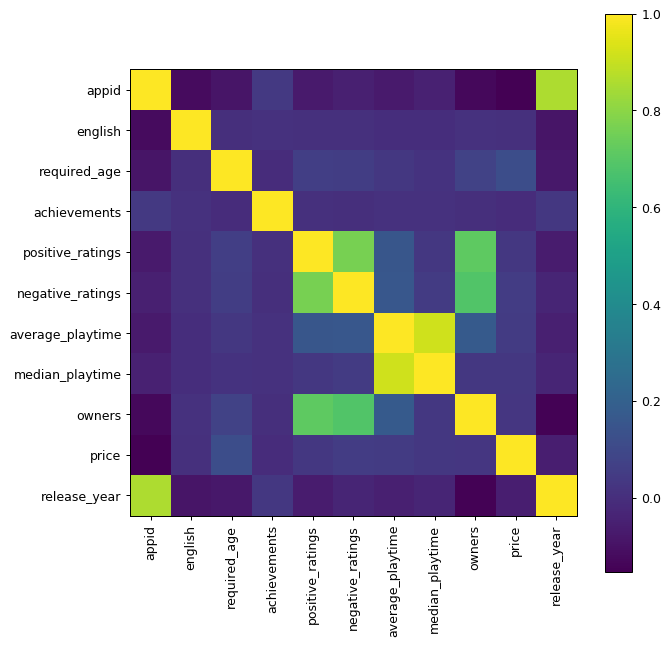

In [125]:
corr = df.corr()
plt.figure(num=None, figsize=(8, 8), dpi=90, facecolor='w', edgecolor='k')
matrix = plt.matshow(corr, fignum = 1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.gca().xaxis.tick_bottom()
plt.colorbar(matrix)
plt.show()

Нет, не может. Кроме очевидных зависимостей ничего интересного не наблюдается.